## 0.参数配置

In [29]:
import time
import os
import sys
BASE_DIR = os.getcwd()
sys.path.append(os.path.join(BASE_DIR, '..'))
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from utils.unet_predictor import UnetPredictor
from nets.unet import Unet as unet

print(BASE_DIR)

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

/mnt/cd1/home/teacher/notebooks/cv_project_2days/image_segmentation/unet-portrait


In [30]:
_defaults = {
    "model_path": 'logs/model_weight_2021_08_20_13_50_54-336-0.95.h5',
    "model_image_size": (224, 224, 3),
    "num_classes": 2,  # 21
}
# path_b = os.path.join(BASE_DIR, "data", "bg1.jpg")
path_b = None
color = "w"  # b:蓝色， r：红色， w：白色
path_img = os.path.join(BASE_DIR, "data", "00079.png")
# path_img = os.path.join(BASE_DIR, "data", "00085.png")
# path_img = os.path.join(BASE_DIR, "data", "00087.png")


## 1.模型创建

In [31]:
# step1：创建预测模型类
# unet = UnetPredictor(_defaults)
model = unet(_defaults["model_image_size"], _defaults["num_classes"])
model.load_weights(_defaults["model_path"])

In [32]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________________________

### Unet模型分析

<img src="./data/unet.png"  width="600" height="700" align="bottom" />

In [33]:
def Unet(input_shape=(256,256,3), num_classes=21):
    inputs = Input(input_shape)
    #-------------------------------#
    #   获得五个有效特征层
    #   feat1   512,512,64
    #   feat2   256,256,128
    #   feat3   128,128,256
    #   feat4   64,64,512
    #   feat5   32,32,512
    #-------------------------------#
    feat1, feat2, feat3, feat4, feat5 = VGG16(inputs) 
      
    channels = [64, 128, 256, 512]

    # 32, 32, 512 -> 64, 64, 512
    P5_up = UpSampling2D(size=(2, 2))(feat5)
    
    # 64, 64, 512 + 64, 64, 512 -> 64, 64, 1024
    P4 = Concatenate(axis=3)([feat4, P5_up])
    # 64, 64, 1024 -> 64, 64, 512
    P4 = Conv2D(channels[3], 3, activation='relu', padding='same', kernel_initializer = RandomNormal(stddev=0.02))(P4)
    P4 = Conv2D(channels[3], 3, activation='relu', padding='same', kernel_initializer = RandomNormal(stddev=0.02))(P4)

    # 64, 64, 512 -> 128, 128, 512
    P4_up = UpSampling2D(size=(2, 2))(P4)
    # 128, 128, 256 + 128, 128, 512 -> 128, 128, 768
    P3 = Concatenate(axis=3)([feat3, P4_up])
    # 128, 128, 768 -> 128, 128, 256
    P3 = Conv2D(channels[2], 3, activation='relu', padding='same', kernel_initializer = RandomNormal(stddev=0.02))(P3)
    P3 = Conv2D(channels[2], 3, activation='relu', padding='same', kernel_initializer = RandomNormal(stddev=0.02))(P3)

    # 128, 128, 256 -> 256, 256, 256
    P3_up = UpSampling2D(size=(2, 2))(P3)
    # 256, 256, 256 + 256, 256, 128 -> 256, 256, 384
    P2 = Concatenate(axis=3)([feat2, P3_up])
    # 256, 256, 384 -> 256, 256, 128
    P2 = Conv2D(channels[1], 3, activation='relu', padding='same', kernel_initializer = RandomNormal(stddev=0.02))(P2)
    P2 = Conv2D(channels[1], 3, activation='relu', padding='same', kernel_initializer = RandomNormal(stddev=0.02))(P2)

    # 256, 256, 128 -> 512, 512, 128
    P2_up = UpSampling2D(size=(2, 2))(P2)
    # 512, 512, 128 + 512, 512, 64 -> 512, 512, 192
    P1 = Concatenate(axis=3)([feat1, P2_up])
    # 512, 512, 192 -> 512, 512, 64
    P1 = Conv2D(channels[0], 3, activation='relu', padding='same', kernel_initializer = RandomNormal(stddev=0.02))(P1)
    P1 = Conv2D(channels[0], 3, activation='relu', padding='same', kernel_initializer = RandomNormal(stddev=0.02))(P1)

    # 512, 512, 64 -> 512, 512, num_classes
    P1 = Conv2D(num_classes, 1, activation="softmax")(P1)

    model = Model(inputs=inputs, outputs=P1)
    return model



## 2.图片预处理

In [34]:
# step2：处理图片
# 做resize，保持长宽比，对于不够的地方，三个通道加127
def letterbox_image(image, size):
    image = image.convert("RGB")
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image,nw,nh
image = Image.open(path_img).convert('RGB')
# 保持长宽比，进行resize
img, nw, nh = letterbox_image(image, (_defaults["model_image_size"][1], _defaults["model_image_size"][0]))

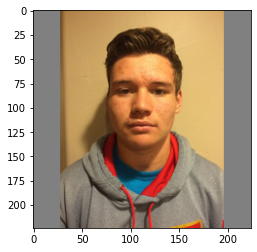

In [35]:
plt.imshow(img) 
# 等比例resize

In [36]:
img = np.asarray([np.array(img)/255])
print(img.shape)

(1, 224, 224, 3)


## 3.前向传播

In [37]:
output = model.predict(img)[0]  # 提出 batchsize 维度

In [38]:
print(output.shape, output.max(), output.min())

(224, 224, 2) 1.0 1.7901965e-14


## 4. 后处理

In [39]:
_defaults["model_image_size"][0]
print(output.shape)

(224, 224, 2)


In [40]:
output = output[:, :, 1].reshape([_defaults["model_image_size"][0], _defaults["model_image_size"][1]])
# 去除填充的灰色边
output = output[int((_defaults["model_image_size"][0]-nh)//2):int((_defaults["model_image_size"][0]-nh)//2+nh),
     int((_defaults["model_image_size"][1]-nw)//2):int((_defaults["model_image_size"][1]-nw)//2+nw)]


In [41]:
# 证件照制作
mask = output

# 创建背景，白色、红色、蓝色
img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)  #
h, w, c = img.shape
if path_b:
    background = cv2.imread(path_b)
    background = cv2.resize(background, (w, h))
else:
    background = np.zeros_like(img, dtype=np.uint8)
    if color == "b":
        background[:, :, 0] = 255
    elif color == "w":
        background[:] = 255
    elif color == "r":
        background[:, :, 2] = 255

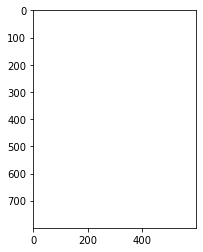

In [42]:
plt.imshow(background)

In [43]:
# 转换mask至BGR通道及指定size，alpha
alpha_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
alpha_bgr = cv2.resize(alpha_bgr, (w, h))
# fusion
result = np.uint8(img * alpha_bgr + background * (1 - alpha_bgr))

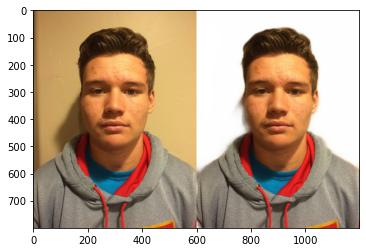

In [44]:

# step3：显示图片
img_bgr = cv2.imread(path_img)
show_img = np.concatenate([img_bgr, result], axis=1)
show_img = cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB)
plt.imshow(show_img)
